**📊 Aadhaar Demographic Data Analysis**

Project Overview: This notebook analyzes Aadhaar enrollment data to identify trends across different States and Union Territories.


**Key Steps:**

Data Loading: Merging multiple CSV datasets.

Data Cleaning: Standardizing state names and handling inconsistencies.

Aggregation: calculating total enrollments per state.

Visualization: Creating bar charts, trend lines, and pie charts to visualize the insights.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Configuration for charts
colors = ["#ce4040", "#6643e4", "#7bdf72"]
plt.style.use('ggplot') # Optional: Makes charts look slightly better

**1. Data Loading and Merging**


We will load multiple CSV files representing different batches of data and concatenate them into a single DataFrame for analysis.

In [3]:
# List of dataset filenames
files = [
    "api_data_aadhar_demographic_0_500000.csv",
    "api_data_aadhar_demographic_500000_1000000.csv",
    "api_data_aadhar_demographic_1000000_1500000.csv",
    "api_data_aadhar_demographic_1500000_2000000.csv",
    "api_data_aadhar_demographic_2000000_2071700.csv"
]

# Read and combine all files
try:
    df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    print(f"✅ Data Loaded Successfully.")
    print(f"Total Records: {len(df):,}")
    print(f"Unique Raw States in data: {df['state'].nunique()}")
except FileNotFoundError:
    print("❌ Error: One or more files not found. Please upload them to the Colab environment.")

✅ Data Loaded Successfully.
Total Records: 664,912
Unique Raw States in data: 63


**2. Data Cleaning & Standardization**


The state column contains various inconsistencies (typos, case sensitivity issues, old state names). We will normalize this data to ensure accurate aggregation.

Cleaning Steps:

Convert to lowercase and strip whitespace.

Map variations (e.g., "Orissa" -> "Odisha") to official names.

Remove invalid entries.

In [4]:
# 1. Basic string cleaning
df["state_clean"] = df["state"].str.lower().str.strip()

# 2. Dictionary to fix typos and standardize names
fix_map = {
    "orissa": "odisha",
    "pondicherry": "puducherry",
    "west bangal": "west bengal",
    "westbengal": "west bengal",
    "west  bengal": "west bengal",
    "west bengli": "west bengal",
    "jammu & kashmir": "jammu and kashmir",
    "andaman & nicobar islands": "andaman and nicobar islands",
    # Mapping cities/districts to states
    "jaipur": "rajasthan",
    "nagpur": "maharashtra",
    "uttaranchal": "uttarakhand",
    "chhatisgarh": "chhattisgarh",
    "darbhanga": "bihar",
    "madanapalle": "andhra pradesh",
    "puttenahalli": "karnataka",
    "raja annamalai puram": "tamil nadu",
    # Merging Daman & Diu / Dadra & Nagar Haveli
    "dadra & nagar haveli": "dadra and nagar haveli and daman and diu",
    "daman and diu": "dadra and nagar haveli and daman and diu",
    "daman & diu": "dadra and nagar haveli and daman and diu",
    "dadra and nagar haveli": "dadra and nagar haveli and daman and diu",
    "balanagar": "telangana",
    # Removing invalid numeric entries
    "100000": None
}

# 3. Apply mapping and drop invalid rows
df["state_clean"] = df["state_clean"].replace(fix_map)
df = df[df["state_clean"].notna()]

print("Step Complete: Data Cleaned.")
print(f"Final Clean Unique States/UTs: {df['state_clean'].nunique()}")

Step Complete: Data Cleaned.
Final Clean Unique States/UTs: 37


**3. Aggregation and Ranking**

We calculate the total enrollments (Age 5-17 + Age 17+) and rank the states.

In [5]:
# Create Total Enrolled column
df["total_enrolled"] = df["demo_age_5_17"] + df["demo_age_17_"]

# Group by state and sum
state_summary = (
    df.groupby("state_clean")["total_enrolled"]
    .sum()
    .reset_index()
    .sort_values(by="total_enrolled", ascending=False)
)

# Reset index for clean processing
state_summary = state_summary.reset_index(drop=True)

# --- Prepare Top 10 ---
top10 = state_summary.head(10).copy()
top10["Top10_Rank"] = range(1, len(top10) + 1)

print("\n⭐️ Top 10 States/UTs by Enrollment:")
print(top10[["Top10_Rank", "state_clean", "total_enrolled"]].to_string(index=False))

# --- Prepare Bottom 10 ---
bottom10 = state_summary.tail(10).copy()
bottom10["Bottom10_Rank"] = range(1, len(bottom10) + 1)

print("\n⚠️ Bottom 10 States/UTs by Enrollment:")
print(bottom10[["Bottom10_Rank", "state_clean", "total_enrolled"]].to_string(index=False))


⭐️ Top 10 States/UTs by Enrollment:
 Top10_Rank    state_clean  total_enrolled
          1  uttar pradesh       2237242.0
          2    maharashtra       1548350.0
          3          bihar       1360866.0
          4    west bengal       1124589.0
          5 madhya pradesh        685641.0
          6      rajasthan        673726.0
          7     tamil nadu        618079.0
          8 andhra pradesh        609842.0
          9   chhattisgarh        531455.0
         10        gujarat        522102.0

⚠️ Bottom 10 States/UTs by Enrollment:
 Bottom10_Rank                              state_clean  total_enrolled
             1                                 nagaland         10356.0
             2                        arunachal pradesh          9502.0
             3                               puducherry          9482.0
             4                                  mizoram          9335.0
             5                                   sikkim          5212.0
             6 dad

**4. Visualizations: Geographic Distribution**
Visualizing the Top 10 and Bottom 10 regions using bar charts.

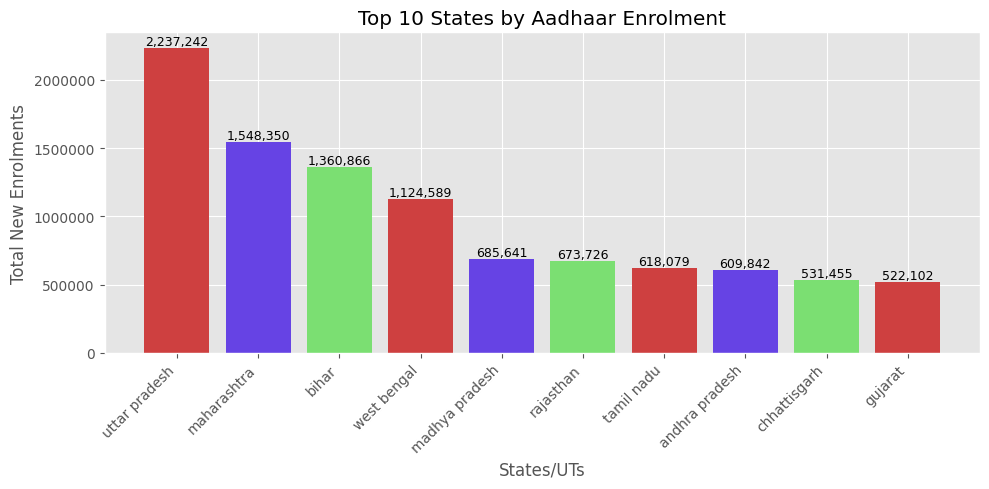

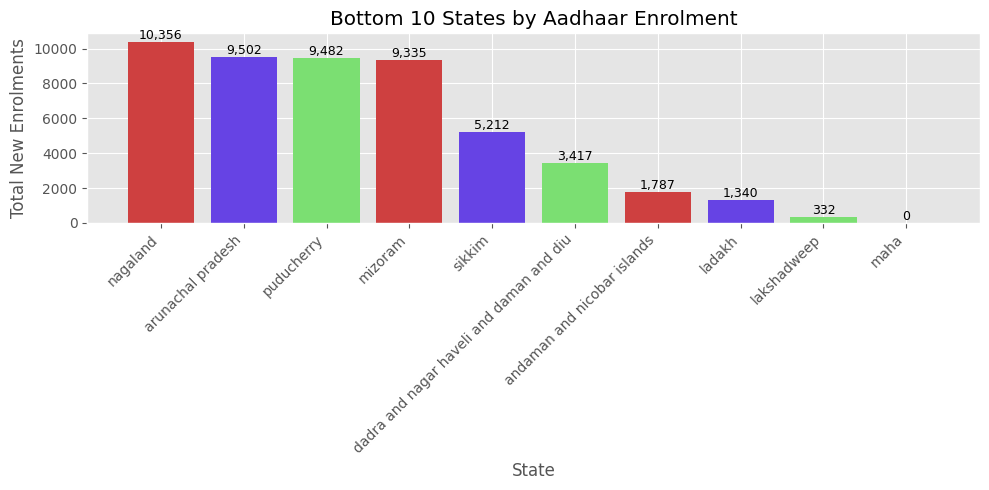

In [6]:
# Function to add labels to bars
def add_labels(bars):
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, h, f"{int(h):,}",
                 ha="center", va="bottom", fontsize=9)

# --- Plot 1: Top 10 States ---
plt.figure(figsize=(10, 5))
bars1 = plt.bar(
    top10["state_clean"],
    top10["total_enrolled"],
    color=colors * 4
)
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 States by Aadhaar Enrolment")
plt.xlabel("States/UTs")
plt.ylabel("Total New Enrolments")
plt.ticklabel_format(style="plain", axis="y") # Disable scientific notation
add_labels(bars1)
plt.tight_layout()
plt.show()

# --- Plot 2: Bottom 10 States ---
plt.figure(figsize=(10, 5))
bars2 = plt.bar(
    bottom10["state_clean"],
    bottom10["total_enrolled"],
    color=colors * 4
)
plt.xticks(rotation=45, ha="right")
plt.title("Bottom 10 States by Aadhaar Enrolment")
plt.xlabel("State")
plt.ylabel("Total New Enrolments")
plt.ticklabel_format(style="plain", axis="y")
add_labels(bars2)
plt.tight_layout()
plt.show()

**5. Time Series Analysis**

Analyzing how enrollments have trended over time. We convert the date column to datetime objects and aggregate daily totals.

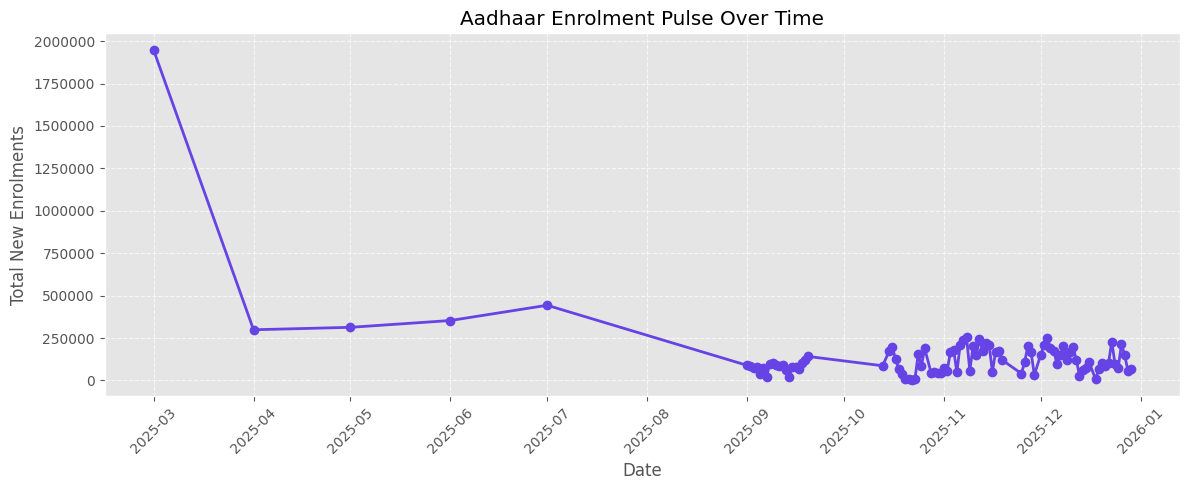

In [7]:
# Convert date column (handling mixed formats automatically)
df["date"] = pd.to_datetime(
    df["date"],
    format="mixed",
    dayfirst=True,
    errors="coerce"
)

# Remove rows with invalid dates
df = df[df["date"].notna()]

# Group by date
daily_pulse = df.groupby("date")["total_enrolled"].sum().reset_index()

# Plot Line Chart
plt.figure(figsize=(12, 5))
plt.plot(
    daily_pulse["date"],
    daily_pulse["total_enrolled"],
    color=colors[1],
    marker="o",
    linewidth=2
)

plt.title("Aadhaar Enrolment Pulse Over Time")
plt.xlabel("Date")
plt.ylabel("Total New Enrolments")
plt.ticklabel_format(style="plain", axis="y")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**6. Demographic Breakdown**

A pie chart representing the split between the two major age groups tracked in this dataset.

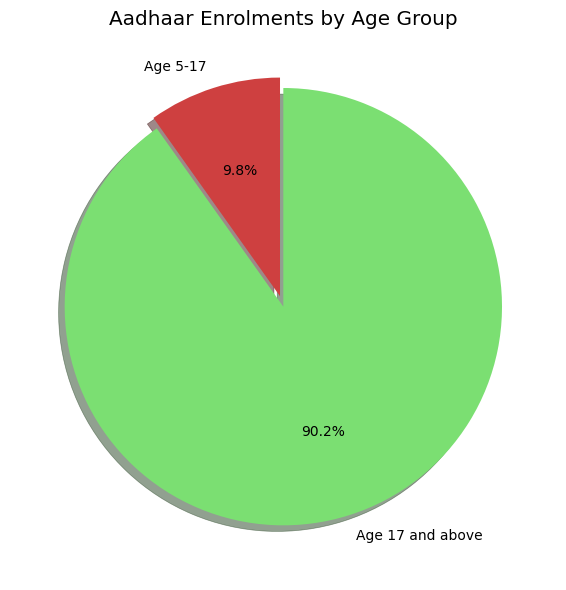

In [8]:
plt.figure(figsize=(6, 6))

# Prepare data for pie chart
data = [
    df["demo_age_5_17"].sum(),
    df["demo_age_17_"].sum()
]
labels = ["Age 5-17", "Age 17 and above"]

plt.pie(
    data,
    labels=labels,
    autopct=lambda p: f"{p:.1f}%",
    startangle=90,
    colors=[colors[0], colors[2]], # Red and Green
    explode=(0.05, 0), # Slightly separate the first slice
    shadow=True
)

plt.title("Aadhaar Enrolments by Age Group")
plt.tight_layout()
plt.show()